# 5 Численное дифференцирование и интегрирование

## 5.4 Составные квадратурные формулы

Импортируем все необходимые библиотеки и сразу опишем нужные нам методы

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from time import perf_counter
from scipy.integrate import quad

In [110]:
def get_weights(points):
    points = np.sort(points)
    n = len(points)
    a = points[0]
    b = points[-1]
    # тут сложновато, но на самом деле это элементарные интерполяционные многочлены
    l = [lambda x : 
        np.prod([(x - points[j]) / (points[i] - points[j]) for j in range(i)]) *
        np.prod([(x - points[j]) / (points[i] - points[j]) for j in range(i + 1, n)])
        for i in range(n)]
    d = np.array([quad(l[i], -1, 1)[0] for i in range(n)]) * (b - a) / 2
    return d

def quadrature(f, x, d):
    return np.sum([f(x[i]) * d[i] for i in range(len(x))])

def composite_appr(f, a, b, k):
    h = (b - a) / k
    x = np.array([np.linspace(l, l + h, 4) for l in np.linspace(a, b - h, k)])
    d = np.full(4, 0.25)
    return h * np.sum([quadrature(f, x[i], d) for i in range(k)])

def approximate_integral(f, a, b, tol=2e-5):
    k = 2
    err = np.inf
    prev = composite_appr(f, a, b, k)
    while err > tol:
        k *= 2
        appr_int = composite_appr(f, a, b, k)
        # Ошибка по формуле Рунге 
        # Алгебраический порядок для квадратуры с 4 узлами >=3
        # Тогда знаменатель в формуле Рунге будет
        # 2^4 - 1 = 15
        # Каждрый раз отрезки делятся пополам
        # И по формуле оценивается на каждом отрезке,
        # так что нужно умножить на их количество
        err = abs(appr_int - prev) / 7
        prev = appr_int
    return appr_int, k

Вычислим веса квадратурной формулы с узлами -1, -1/3, 1/3, 1. Для этого построим элементарные интерполяционные многочлены по такой сетке и проинтегрируем их, не забывая в конце домножить на (b-a) / 2

In [111]:
print(f"Для точек {np.round([-1, -1/3, 1/3, 1], 4)} \nВеса квадратурной формулы {np.round(get_weights([-1, -1/3, 1/3, 1]), 4)}")

Для точек [-1.     -0.3333  0.3333  1.    ] 
Веса квадратурной формулы [0.25 0.25 0.25 0.25]


Используй мы более хитрые сетки, пришлось бы пересчитывать веса для каждой сетки. Но так как сетка у нас равномерная, меняться в весах будет только длина отрезка, поэтому мы их зафиксируем, а на длину домножим в конце для сохранения точности.

Теперь перейдем к интегрированию. Для этого определим еще одну функцию, которая будет строить нам графики для разных f, a и b. Также она будет выводить разницу между последним приближением и интегралом, посчитанным `integrate.quad`, чтобы убедиться, что метод работает корректно.

In [135]:
def plot_appr(f, a, b):
    tol_arr = 2.0 ** (-np.arange(5, 31, 4))
    k_arr = []
    for tol in tol_arr:
        appr_int, k= approximate_integral(f, a, b, tol)
        k_arr.append(k)
    plt.loglog(tol_arr, k_arr, 'ko', label = 'Our method')
    theor = 1 / (tol_arr ** (1/2))
    theor *= k_arr[-1] / theor[-1]
    plt.loglog(tol_arr, theor, 'r-', label = 'Theoretical')
    plt.xlabel("$tol$")
    plt.ylabel("Intervals")
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Last approzimation error comaperd to integrate.quad: {abs(quad(f, a, b, epsabs=1e-10)[0] - appr_int)}")

Теоретическая оценка на количество интервалов разбиения получается из следующих соображений: ошибка метода $E = O(h^{p - 1})$, где $h$ --- длина отрезка разбиения, а $p$ --- алгебраическая точность метода на отрезке. На отрезке мы используем интерполяционную формулу 4й степени, следовательно, $p = 3$. Тогда, для получения ошибки, не превышающей $tol$, потребуется шагов:
$$E = O(h^2), \: E \leq tol \Rightarrow h \leq O(\sqrt{tol}) \Rightarrow$$
$$\Rightarrow \frac{b-a}{N} \leq O(\sqrt{tol}) \Rightarrow N \geq O(\sqrt{\frac{1}{tol}}).$$

Поэтому мы возьмем $tol^{-1/2}$ как теоретическую оценку и подправим ее на коэффициент по последнему запуску. Тогда мы отследим, как меняется требуемое число шагов нашего метода по сравнению с теоретической оценкой на число шагов.

Самая маленькая ошибка, которой мы потребуем, будет $2^{-29} \approx 1.9e9$. Поэтому хочется ожидать, что ошибка нашего метода относительно `integrate.quad` будет тех же порядков.

Начнем с косинуса на \[-1;1\].

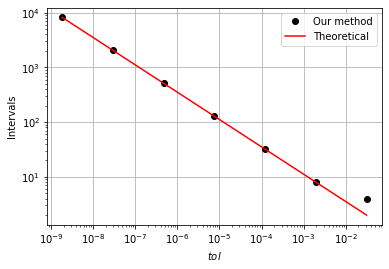

Last approzimation error comaperd to integrate.quad: 2.7864213159034534e-09


In [136]:
plot_appr(lambda x : np.cos(x), -1, 1)

Теперь попробуем простой многочлен на отрезке \[0;2\].

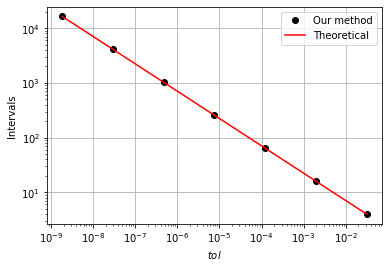

Last approzimation error comaperd to integrate.quad: 1.655684034318483e-09


In [137]:
plot_appr(lambda x : x ** 2, 0, 2)

Теперь синус на отрезке \[0;5\].

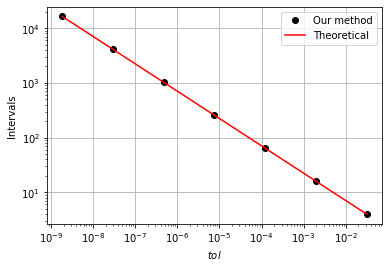

Last approzimation error comaperd to integrate.quad: 1.8531707279834109e-09


In [138]:
plot_appr(lambda x : np.sin(x), 0, 5)

И напоследок комбинацию посложнее на новом отрезке.

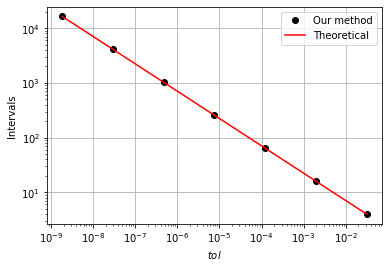

Last approzimation error comaperd to integrate.quad: 1.1961613921585013e-09


In [139]:
plot_appr(lambda x : (np.cos(x) ** 2 + np.sin(x) + x - 3), -2, 3)

Для всех функций наш метод корректно приближает интеграл, разница с `integrate.quad` соответствует оценке ошибки формулой Рунге, а необходимое число шагов метода меняется в соответствии с теоретической оценкой. 